In [1]:
#data and reps from here:
#https://github.com/henanjun/LCMR/blob/1/LCMR/LCMR_demo.m

#demo for LCMR to be appeared TGRS if you use code, please kind cite the paper, "A New Spatial-Spectral Feature Extraction Method for Hyperspectral Images Using Local Covariance Matrix Representation" Leyuan Fang et al. to be appeared TGRS

import numpy as np


from hand_utils import *

import sys
sys.path.append('../')
from scripts import flag_dimensionality_reduction as fdr
from scripts.utils import *


from matplotlib import pyplot as plt
from geomstats.geometry.pre_shape import PreShapeSpace


from scipy.linalg import eigh


INFO: Using numpy backend


In [2]:
class GeomstatsShapeSpace():
    """A simple adapter class which uses pymanopt language for geomstats shape space
    """

    def __init__(self, n, k):
        self._man = PreShapeSpace(m_ambient = n, k_landmarks = k)
        self._man.equip_with_group_action("rotations")
        self._man.equip_with_quotient_structure()

    def dist(self, point_a, point_b):
        return self._man.metric.dist(point_a, point_b)

    def exp(self, base_point, tangent_vector):
        return self._man.metric.exp(tangent_vector, base_point=base_point)

    def log(self, base_point, ambient_point):
        return self._man.to_tangent(ambient_point, base_point=base_point)
    
    def random_point(self):
        return self._man.random_point()


# Experiments with one outlier

In [3]:
   
def WPGA0(manifold, data: list, fl_type: list, return_ts: bool = False, eps: float = 1e-5, init_seed = 42, median = []):
    '''
    tangent space version of L2-WPCA
    '''

    t_data = []
    for i in range(len(data)):
        t = manifold.log(median, data[i]).flatten()
        t_data.append(t)

    t_data = np.vstack(t_data).T

    pds = WPCA_L2(t_data, fl_type[-1], init_seed = init_seed)


    if return_ts:
        return pds, t_data
    else:
        return pds

def WPCA_L2(X, k, init_seed = 123, eps_wt = 1e-8 , eps: float = 1e-10,  max_iter: int = 1000):
    '''
    WPCA-L2 Code
    from https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8119535&casa_token=RO14HRIjf5UAAAAA:FXvg29pDDWh7AT6-VEj0ERFlHY4wM6nYUejcziYqt8y3yTTGcoQauH8Owo8a0riXa9Wc4BAogg&tag=1
    '''


    n,p = X.shape

    U,_,_ = np.linalg.svd(X)
    W = U[:,:k]

    dJ = 1
    J = 0
    i=1

    while i < max_iter and dJ > eps*J:

        W0 = W.copy()
        J = np.sum(np.linalg.norm(X.T - X.T @ W0 @ W0.T, axis = 1))
    
        D = np.zeros((p,p))
        for i in range(p):
            x = X[:,[i]]
            wt = np.linalg.norm(x - W0 @ W0.T @ x)
            wt = np.max([wt,eps_wt])
            D[i,i] = 1/wt
        
        C = X @ D @ X.T

        _, Wall = eigh(C)

        W = Wall[:,-k:]

        Bj = np.sum(np.linalg.norm(X.T - X.T @ W@ W.T, axis = 1))
        

        dJ = J - Bj
        i+=1


    return W


In [4]:
filepath = './all/shapes'
segmentationlist = readSegmentations(filepath,getxy)[0]
hands = np.array(segmentationlist).T


shapes = []
for h in hands:
    k_shape = unmake_1d(h)
    k_shape = k_shape - np.mean(k_shape, axis = 0)
    k_shape = k_shape/np.linalg.norm(k_shape)
    shapes.append(k_shape)

shapes = shapes

for i in range(5):
    outlier = generate_hairball_outlier(i+10)
    shapes.append(outlier)

np.linalg.norm(k_shape, axis = 0), np.mean(k_shape, axis = 0)

manifold = GeomstatsShapeSpace(2,56)

In [5]:
#compute median
mean_seed = 21
median = fdr.karcher_median(manifold, shapes)
mean = fdr.karcher_mean(manifold, shapes)

In [8]:
dr_seed = 42
fl_type = [1]

#baseline L2-WPGA
W_base = WPGA0(manifold, shapes, [fl_type[-1]], return_ts= False, init_seed = dr_seed , median = median)

# flag method L2-WPGA
[W_wours,_,_], ts = fdr.flag_robust_tpca(manifold, shapes, fl_type = fl_type, pca_type = 'wpca', 
                               return_ts= True, median = median, init = 'rand', rand_seed = dr_seed,
                               verbose = True)

# flag method L2-RPGA
[W_rours,_,_], ts = fdr.flag_robust_tpca(manifold, shapes, fl_type = fl_type, pca_type = 'rpca', 
                               return_ts= True, median = median, init = 'rand', rand_seed = dr_seed,
                               verbose = True)

#PCA
W_pca, _, ts_pca, mean = PGA0(manifold, shapes, [fl_type[-1]], return_ts = True, eps = 1e-9)

--------------------
iteration 0
objective 11.952230281858247
flag distance between B0 and B1 0.984976510151333

--------------------
iteration 1
objective 11.490381647922895
flag distance between B0 and B1 0.3874131586304798

--------------------
iteration 2
objective 11.163412442374137
flag distance between B0 and B1 0.2712585649913098

--------------------
iteration 3
objective 10.923419296870604
flag distance between B0 and B1 0.20103617878683164

--------------------
iteration 4
objective 10.786123044688548
flag distance between B0 and B1 0.1412022959207165

--------------------
iteration 5
objective 10.708521242162112
flag distance between B0 and B1 0.10038261725723323

--------------------
iteration 6
objective 10.648918647591486
flag distance between B0 and B1 0.08663544585876246

--------------------
iteration 7
objective 10.595989289772906
flag distance between B0 and B1 0.08110641681089782

--------------------
iteration 8
objective 10.543678086816747
flag distance between B

In [9]:
#errors

idx = 40
err_wours = reconst_err_man(manifold, median, shapes[:idx], ts[:,:idx], W_wours)
err_rours = reconst_err_man(manifold, median, shapes[:idx], ts[:,:idx], W_rours)
err_base = reconst_err_man(manifold,  median, shapes[:idx], ts[:,:idx], W_base)
err_pca  = reconst_err_man(manifold,  mean, shapes[:idx], ts_pca[:,:idx], W_pca)

print('without outliers')
print()
print('ours (WPCA)')
print(np.sum(err_wours))
print('ours (RPCA)')
print(np.sum(err_rours))
print('base')
print(np.sum(err_base))
print('pca')
print(np.sum(err_pca))
print('---------')
print('---------')

print()
print()


idx = len(shapes)
err_wours = reconst_err_man(manifold, median, shapes[:idx], ts[:,:idx], W_wours)
err_rours = reconst_err_man(manifold, median, shapes[:idx], ts[:,:idx], W_rours)
err_base = reconst_err_man(manifold, median, shapes[:idx], ts[:,:idx], W_base)
err_pca  = reconst_err_man(manifold, mean, shapes[:idx], ts_pca[:,:idx], W_pca)

print('with outliers')
print()
print('ours (WPCA)')
print(np.sum(err_wours))
print('ours (RPCA)')
print(np.sum(err_rours))
print('base')
print(np.sum(err_base))
print('pca')
print(np.sum(err_pca))

without outliers

ours (WPCA)
5.354220989213683
ours (RPCA)
6.200383350141909
base
5.354242419736627
pca
8.18560092655759
---------
---------


with outliers

ours (WPCA)
13.074145450041414
ours (RPCA)
13.696881888321412
base
13.074155593392165
pca
14.563658306889959


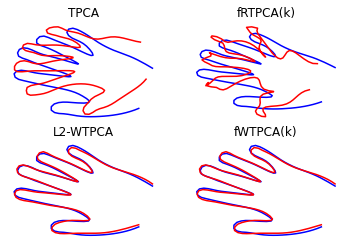

In [10]:
# plot the data for the reconstructions

_, rec_data_base =  reconst_err_man(manifold, median, shapes, ts, W_base ,return_data = True)
_, rec_data_wours = reconst_err_man(manifold, median, shapes, ts, W_wours ,return_data = True)
_, rec_data_rours = reconst_err_man(manifold, median, shapes, ts, W_rours ,return_data = True)
_, rec_data_pca =   reconst_err_man(manifold, mean, shapes, ts_pca, W_pca, return_data = True)

W=256
H=256

pt_num = 6


fig, axs = plt.subplots(2,2)
# plt.suptitle(f'Hand {pt_num}')
interp_points = interp(shapes[pt_num])
axs[0,0].plot(interp_points[0]*W,interp_points[1]*H, c = 'b')
interp_points = interp(rec_data_pca[pt_num])
axs[0,0].plot(interp_points[0]*W,interp_points[1]*H, c = 'r')
axs[0,0].axis('off')
axs[0,0].set_title('TPCA')

interp_points = interp(shapes[pt_num])
axs[0,1].plot(interp_points[0]*W,interp_points[1]*H, c = 'b')
interp_points = interp(rec_data_rours[pt_num])
axs[0,1].plot(interp_points[0]*W,interp_points[1]*H, c = 'r')
axs[0,1].axis('off')
axs[0,1].set_title('fRTPCA(k)')

interp_points = interp(shapes[pt_num])
axs[1,0].plot(interp_points[0]*W,interp_points[1]*H, c = 'b')
interp_points = interp(rec_data_base[pt_num])
axs[1,0].plot(interp_points[0]*W,interp_points[1]*H, c = 'r')
axs[1,0].axis('off')
axs[1,0].set_title('L2-WTPCA')


interp_points = interp(shapes[pt_num])
axs[1,1].plot(interp_points[0]*W,interp_points[1]*H, c = 'b', label = 'Ground Truth')
interp_points = interp(rec_data_wours[pt_num])
axs[1,1].plot(interp_points[0]*W,interp_points[1]*H, c = 'r', label = 'Reconstruction')
axs[1,1].axis('off')
axs[1,1].set_title('fWTPCA(k)')


plt.savefig('../Results/hairball_hand_qual.pdf', bbox_inches = 'tight')
# plt.legend()

